# Supervised Learning 


- Decision trees with some form of pruning
- Neural networks
- Boosting
- Support Vector Machines
- k-nearest neighbors


## Table of contents <a name="menu"></a>

1. [Data Pre-processing](#dataprocess)
    1. [Label Encoding](#labelencode)
    2. [Scale and change dtype](#scale)
    3. [Splitting the data (no CV)](#split)
2. [Feature Engineering](#featureengi)
    1. [Feature importance](#featureimportance)
3. [Models](#models)
4. [Learning curves for "one-shot" algorithms](#learningcurves)
5. [Cross-validation](#crossval)

In [105]:
import time
import datetime

import copy
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [106]:
INPUT_DATA = 'costa_rican_data/'
TRAIN_CSV = 'train.csv'

FIG_PATH = 'figures/costa_rican/'

RANDOM_STATE = 17

In [107]:
train_csv = pd.read_csv(INPUT_DATA+TRAIN_CSV)
print(train_csv.shape)
train_csv.head()

(9557, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


# Data Pre-processing <a name="dataprocess"></a>
[Table of Content](#menu)

In [108]:
features = [col for col in train_csv.columns if col not in ['Id', 'Target', 'idhogar']]
print(len(features))

140


In [109]:
train_csv['Target'] = train_csv['Target'] - 1 # Have the target values starting from 0
target_values = train_csv['Target'].values
print(len(target_values))

9557


## Label encoding <a name="labelencode"></a>
[Table of Content](#menu)

In [110]:
non_numerical_features = list(set(features) - set(train_csv._get_numeric_data().columns))
train_csv[non_numerical_features].head()

,edjefa,edjefe,dependency
0,no,10,no
1,no,12,8
2,11,no,8
3,no,11,yes
4,no,11,yes


According to codebook.csv:
- idhogar is Household level identifier
- dependency is Dependency Rate
- edjefe is years of education of male head of household
- edjefa is years of education of female head of household

So we can encode idhogar without any issue. But for the other, since we have some yes and no values, we have to attribute no to 0 and yes to 1.

In [111]:
yes_no_features = [x for x in non_numerical_features]
train_csv[yes_no_features] = train_csv[yes_no_features].replace({'no': 0, 'yes':1}).astype(float)
train_csv[non_numerical_features].head()

,edjefa,edjefe,dependency
0,0.0,10.0,0.0
1,0.0,12.0,8.0
2,11.0,0.0,8.0
3,0.0,11.0,1.0
4,0.0,11.0,1.0


In [112]:
nan_array = train_csv.isnull().sum().values/train_csv.shape[0]*100
df_nan = pd.DataFrame(nan_array, columns=['Count'], index=train_csv.columns)
df_nan = df_nan.sort_values(by=['Count'], ascending=False)
counter_nan = df_nan[df_nan['Count']>0].shape[0]

print(f'{counter_nan} rows have nan values.')
df_nan.head(10)

5 rows have nan values.


,Count
rez_esc,82.954902
v18q1,76.823271
v2a1,71.779847
SQBmeaned,0.052318
meaneduc,0.052318
Id,0.000000
hogar_adul,0.000000
parentesco10,0.000000
parentesco11,0.000000
parentesco12,0.000000


In [113]:
train_csv = train_csv.fillna(0)

In [114]:
nan_array = train_csv.isnull().sum().values/train_csv.shape[0]*100
df_nan = pd.DataFrame(nan_array, columns=['Count'], index=train_csv.columns)
df_nan = df_nan.sort_values(by=['Count'], ascending=False)
counter_nan = df_nan[df_nan['Count']>0].shape[0]

print(f'{counter_nan} rows have nan values.')
df_nan.head(10)

0 rows have nan values.


,Count
Id,0.0
hogar_mayor,0.0
parentesco10,0.0
parentesco11,0.0
parentesco12,0.0
idhogar,0.0
hogar_nin,0.0
hogar_adul,0.0
hogar_total,0.0
parentesco8,0.0


## Scale and change dtype <a name="scale"></a>
[Table of Content](#menu)

In [115]:
threshold_cate = 25

col_continuous = []
col_categorical = []

for col in features:
    new_col = sorted(list(set(train_csv[col])))
    #print()
    #print(col)
    #print(new_col)
    min_col = np.min(new_col)
    max_col = np.max(new_col)

    if max_col > threshold_cate or col in ['age']:
        col_continuous.append(col)
        continue

    col_categorical.append(col)

In [116]:
train_csv[col_continuous]

,v2a1,meaneduc,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,190000.0,10.00,43,100,1849,1,100,0,1.000000,0.0000,100.0000,1849
1,135000.0,12.00,67,144,4489,1,144,0,1.000000,64.0000,144.0000,4489
2,0.0,11.00,92,121,8464,1,0,0,0.250000,64.0000,121.0000,8464
3,180000.0,11.00,17,81,289,16,121,4,1.777778,1.0000,121.0000,289
4,180000.0,11.00,37,121,1369,16,121,4,1.777778,1.0000,121.0000,1369
...,...,...,...,...,...,...,...,...,...,...,...,...
9552,80000.0,8.25,46,81,2116,25,81,1,1.562500,0.0625,68.0625,2116
9553,80000.0,8.25,2,0,4,25,81,1,1.562500,0.0625,68.0625,4
9554,80000.0,8.25,50,25,2500,25,81,1,1.562500,0.0625,68.0625,2500
9555,80000.0,8.25,26,121,676,25,81,1,1.562500,0.0625,68.0625,676


In [117]:
scaler = StandardScaler()
data2scale = train_csv[col_continuous]
scaler.fit(data2scale)
scaled_cols = scaler.transform(data2scale)
train_csv[col_continuous] = scaled_cols

In [118]:
# Put as int
train_csv[col_categorical] = train_csv[col_categorical].astype('int')

In [119]:
train_csv.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,1.313389,0,3,0,1,1,0,0,0,...,0.335757,0.117871,-0.967066,0.592794,-0.553536,-0.544758,-0.311754,-0.027109,0.117871,3
1,ID_f29eb3ddd,0.809548,0,4,0,1,1,1,1,0,...,0.908871,1.634149,-0.967066,1.153720,-0.553536,-0.544758,4.803672,0.443393,1.634149,3
2,ID_68de51c94,-0.427153,0,8,0,1,1,0,0,0,...,0.609289,3.917180,-0.967066,-0.682039,-0.553536,-0.726385,4.803672,0.197449,3.917180,3
3,ID_d671db89c,1.221781,0,5,0,1,1,1,1,0,...,0.088276,-0.778111,-0.167084,0.860508,0.022340,-0.356403,-0.231825,0.197449,-0.778111,3
4,ID_d56d6f5f5,1.221781,0,5,0,1,1,1,1,0,...,0.609289,-0.157816,-0.167084,0.860508,0.022340,-0.356403,-0.231825,0.197449,-0.157816,3


## Splitting the data (without cross-validation) <a name="split"></a>
[Table of Content](#menu)

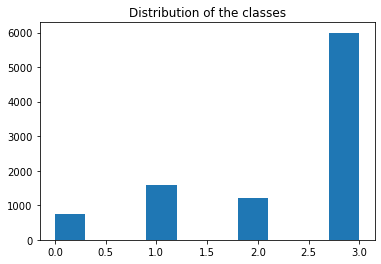

In [120]:
plt.title("Distribution of the classes")
plt.hist(train_csv[['Target']].values)
plt.show()

In [121]:
training_df, test_df = train_test_split(train_csv, test_size=0.2, random_state=RANDOM_STATE, stratify=train_csv[['Target']])
train_df, val_df = train_test_split(training_df, test_size=0.2, random_state=RANDOM_STATE, stratify=training_df[['Target']])

print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (6116, 143)
Validation set shape: (1529, 143)
Test set shape: (1912, 143)


In [122]:
x_training = np.array(training_df[features])
y_training = np.array(training_df['Target'])

x_train = np.array(train_df[features])
y_train = np.array(train_df['Target'])

x_val = np.array(val_df[features])
y_val = np.array(val_df['Target'])

x_test = np.array(test_df[features])
y_test = np.array(test_df['Target'])

# Data Pre-processing with Feature Engineering <a name="featureengi"></a>
[Table of Content](#menu)

Taken from: https://www.kaggle.com/jeppbautista/eda-feature-engineering-lgbm

In [125]:
def feature_engineer(x_original):
    x = x_original.copy()
    x['escolari_age'] = x['escolari'] / x['age']
    x['refrig'] = x['refrig'].astype(int)
    x['computer'] = x['computer'].astype(int)
    x['television'] = x['television'].astype(int)
    x['mobilephone'] = x['mobilephone'].astype(int)
    x['v14a'] = x['v14a'].astype(int)
    x['v18q'] = x['v18q'].astype(int)
    x['epared1'] = x['epared1'].astype(int)
    x['epared2'] = x['epared2'].astype(int)
    x['epared3'] = x['epared3'].astype(int)
    x['etecho1'] = x['etecho1'].astype(int)
    x['etecho2'] = x['etecho2'].astype(int)
    x['etecho3'] = x['etecho3'].astype(int)
    
    x['eviv1'] = x['eviv1'].astype(int)
    x['eviv2'] = x['eviv2'].astype(int)
    x['eviv3'] = x['eviv3'].astype(int)
    x['abastaguadentro'] = x['abastaguadentro'].astype(int)
    x['abastaguafuera'] = x['abastaguafuera'].astype(int)
    x['abastaguano'] = x['abastaguano'].astype(int)
    x['abastaguano'] = x['abastaguano'].astype(int)
    x[['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']] = x[['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']].apply(pd.to_numeric)
    
    x['appliances'] = (x['refrig'] + x['computer'] + x['television'])

    x['rent_by_hhsize'] = x['v2a1'] / x['hhsize'] # rent by household size
    x['rent_by_people'] = x['v2a1'] / x['r4t3'] # rent by people in household
    x['rent_by_rooms'] = x['v2a1'] / x['rooms'] # rent by number of rooms
    x['rent_by_living'] = x['v2a1'] / x['tamviv'] # rent by number of persons living in the household
    x['rent_by_minor'] = x['v2a1'] / x['hogar_nin']
    x['rent_by_adult'] = x['v2a1'] / x['hogar_adul']
    x['rent_by_dep'] = x['v2a1'] / x['dependency']
    x['rent_by_head_educ'] = x['v2a1'] / (x['edjefe'] + x['edjefa'])
    x['rent_by_educ'] = x['v2a1'] / x['meaneduc']
    x['rent_by_numPhone'] = x['v2a1'] / x['qmobilephone']
    x['rent_by_gadgets'] = x['v2a1'] / (x['computer'] + x['mobilephone'] + x['v18q'])
    x['rent_by_num_gadgets'] = x['v2a1'] / (x['v18q1'] + x['qmobilephone'])
    x['rent_by_appliances'] = x['v2a1'] / x['appliances']
    
    x['under12'] = x['r4t1']/x['r4t3']
    x['under12_male'] = x['r4h1']/x['r4t3']
    x['under12_female'] = x['r4m1']/x['r4t3']
    x['Proportion_male'] = x['r4h3']/x['r4t3']
    x['Proportion_female'] = x['r4m3']/x['r4t3']
    
    x['tablet_density'] = x['v18q1'] / x['r4t3']
    x['phone_density'] = x['qmobilephone'] / x['r4t3']
    
    x['wall_qual'] = x['epared3'] - x['epared1']
    x['roof_qual'] = x['etecho3'] - x['etecho1']
    x['floor_qual'] = x['eviv3'] - x['eviv1']
    x['water_qual'] = x['abastaguadentro'] - x['abastaguano']
    
    x['house_qual'] = x['wall_qual'] + x['roof_qual'] + x['floor_qual']
    
    x['person_per_room'] = x['hhsize'] / x['rooms']
    x['person_per_appliances'] = x['hhsize'] / x['appliances']
    
    x['educ_qual'] = (1 * x['instlevel1']) + (2 * x['instlevel2']) + (3 * x['instlevel3']) + (4 * x['instlevel4']) + (5 * x['instlevel5']) + (6 * x['instlevel6']) + ( 7 * x['instlevel7']) + (8 * x['instlevel8']) + (9 * x['instlevel9'])
    x['educ_by_individual'] = x['escolari']/x['r4t3']
    x['educ_by_adult'] = x['escolari']/(x['r4t3'] - x['r4t1'])
    x['educ_by_child'] = x['escolari']/x['r4t1']
    
    x['max_educ'] = np.max(x[['edjefa','edjefe']])
    
    def reverse_label_encoding(row, df):
        for c in df.columns:
            if row[c] == 1:
                return int(c[-1])
            
    def rate_sanitary(row, df):
        c = df.columns.tolist()[0]
        
        if row[c] == 'sanitario2':
            return 3
        elif row[c] == 'sanitario3':
            return 2
        elif row[c] == 'sanitario5':
            return 1
        else:
            return 0
        
    def rate_cooking(row, df):
        c = df.columns.tolist()[0]
        
        if row[c] == 'energcocinar2':
            return 3
        elif row[c] == 'energcocinar3':
            return 2
        elif row[c] == 'energcocinar4':
            return 1
        else:
            return 0
        
    def rate_rubbish(row, df):
        c = df.columns.tolist()[0]
        
        if row[c] == 'elimbasu1':
            return 1
        elif row[c] == 'elimbasu2':
            return 2
        else:
            return 0
            
    x['sanitary'] = x.apply(lambda q: reverse_label_encoding(q, x[['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']]), axis=1)
    x['cooking'] =  x.apply(lambda q: reverse_label_encoding(q, x[['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']]), axis=1)
    x['rubbish'] = x.apply(lambda q: reverse_label_encoding(q, x[['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']]), axis=1)
    x['region'] = x.apply(lambda q: reverse_label_encoding(q, x[['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']]), axis=1)
    
    x['sanitary_i'] = x.apply(lambda q: rate_sanitary(q, x[['sanitary']]), axis = 1)
    x['cooking_i'] = x.apply(lambda q: rate_cooking(q, x[['cooking']]), axis = 1)
    x['rubbish_i'] = x.apply(lambda q: rate_rubbish(q, x[['rubbish']]), axis = 1)
    
    x['zone'] = x['area1'] - x['area2']

    x.replace([np.inf, -np.inf], 0, inplace = True)
    x.fillna(0, inplace = True)
    
    return x

In [126]:
training_fe_df = feature_engineer(train_csv)

In [127]:
print(training_fe_df.shape)
training_fe_df.head()

(9557, 185)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,educ_by_child,max_educ,sanitary,cooking,rubbish,region,sanitary_i,cooking_i,rubbish_i,zone
0,ID_279628684,1.313389,0,3,0,1,1,0,0,0,...,0.0,0.0,2,3,1,1,0,0,0,1
1,ID_f29eb3ddd,0.809548,0,4,0,1,1,1,1,0,...,0.0,0.0,2,2,1,1,0,0,0,1
2,ID_68de51c94,-0.427153,0,8,0,1,1,0,0,0,...,0.0,0.0,2,2,1,1,0,0,0,1
3,ID_d671db89c,1.221781,0,5,0,1,1,1,1,0,...,9.0,0.0,2,2,1,1,0,0,0,1
4,ID_d56d6f5f5,1.221781,0,5,0,1,1,1,1,0,...,11.0,0.0,2,2,1,1,0,0,0,1


In [128]:
def agg_features(x):
    y = x.copy()
    mean_list = []
    count_list = ['escolari_age', 'phone_density', 'rez_esc', 'dis', 'male', 'female','v2a1','house_qual', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total', 'escolari','estadocivil1','estadocivil2','estadocivil3','estadocivil4','estadocivil5','estadocivil6','estadocivil7','parentesco1', 'parentesco2', 'parentesco3',
                 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12']
                
    for group in ['idhogar']:            
        for item in count_list:
            for agg_m in ['mean','std','min','max','sum']:
                id_agg = y[item].groupby(y[group]).agg(agg_m)
                new_col = item + '_' + agg_m + '_' + group 
                y[new_col] = id_agg
                
    drop_ = ['sanitary', 'cooking', 'rubbish', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
            'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'tamhog', 'tamviv', 'hhsize', 'v18q', 
             'v14a', 'agesq','mobilephone', 'female', 'estadocivil1','estadocivil2','estadocivil3','estadocivil4','estadocivil5','estadocivil6','estadocivil7', 'parentesco2', 'parentesco3',
                 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12', 'lugar1', 'lugar2', 'lugar3', 'lugar4', 
             'lugar5', 'lugar6', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
            'r4t1', 'r4t2', 'r4t3']
    
    y.drop((drop_), inplace = True, axis = 1)
    y.replace([np.inf, -np.inf], 0, inplace = True)
    y.fillna(0, inplace = True)

    return y

In [129]:
training_fe_df = agg_features(training_fe_df).reset_index(drop=True)

In [130]:
print(training_fe_df.shape)
training_fe_df.head()

(9557, 278)


,Id,v2a1,hacdor,rooms,hacapo,refrig,v18q1,r4h1,r4h2,r4h3,...,parentesco11_mean_idhogar,parentesco11_std_idhogar,parentesco11_min_idhogar,parentesco11_max_idhogar,parentesco11_sum_idhogar,parentesco12_mean_idhogar,parentesco12_std_idhogar,parentesco12_min_idhogar,parentesco12_max_idhogar,parentesco12_sum_idhogar
0,ID_279628684,1.313389,0,3,0,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_f29eb3ddd,0.809548,0,4,0,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_68de51c94,-0.427153,0,8,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_d671db89c,1.221781,0,5,0,1,1,0,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_d56d6f5f5,1.221781,0,5,0,1,1,0,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
x_train_fe_df = training_fe_df[training_fe_df.columns.difference(['Target','Id','idhogar'])]
y_train_fe_df = training_fe_df[['Target']]

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
randomf_clf = RandomForestClassifier()
randomf_clf.fit(x_train_fe_df, y_train_fe_df)

imp = randomf_clf.feature_importances_
name = np.array(x_train_fe_df.columns.values.tolist())


df_imp = pd.DataFrame({'feature':name, 'importance':imp})
df_imp = df_imp.sort_values(by='importance', ascending=False)

D:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [134]:
# https://www.kaggle.com/skooch/lgbm-with-random-split/notebook

def feature_importance(forest, X_train):
    ranked_list = []

    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " + X_train.columns[indices[f]])
        ranked_list.append(X_train.columns[indices[f]])
    
    return ranked_list   

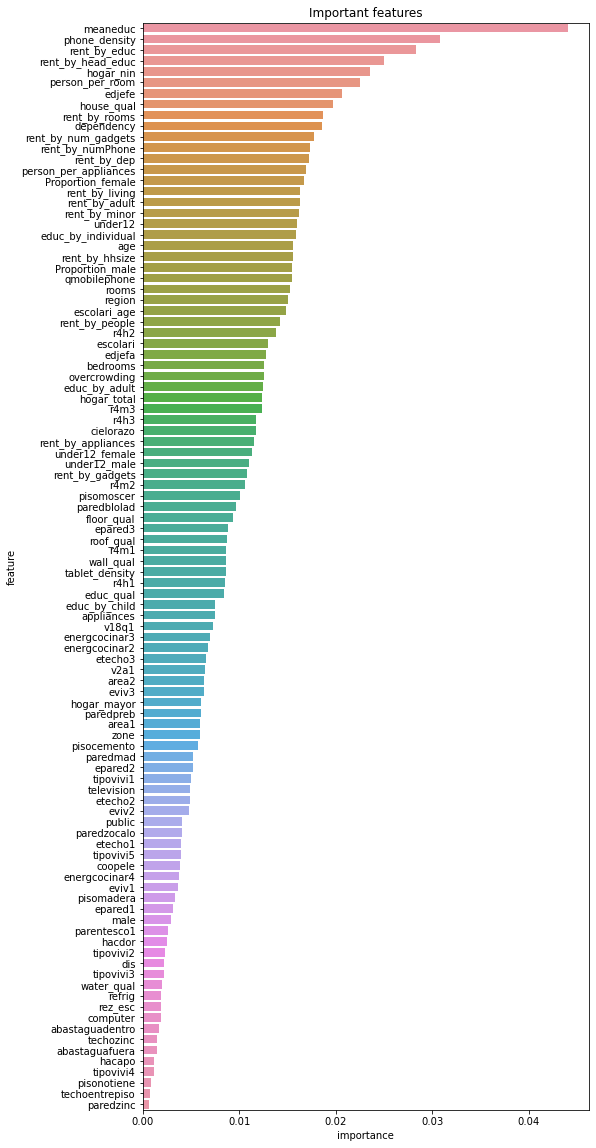

In [135]:
plt.figure(figsize=(8,20))
sns.barplot(df_imp.loc[(df_imp['importance'] > 0.0005),'importance'], y = df_imp.loc[(df_imp['importance'] > 0.0005),'feature'])
plt.title('Important features')
plt.show()

## Feature importance threshold <a name="featureimportance"></a>
[Table of Content](#menu)

TODO: Modify it and give accuracy graph

In [136]:
threshold = 0.001

In [137]:
important_cols = df_imp.loc[(df_imp['importance']>threshold),'feature']

In [138]:
print(training_fe_df.shape)
training_fe_df_final = training_fe_df[important_cols].reset_index(drop=True)
training_fe_df_final['Target'] = y_train_fe_df

(9557, 278)


In [139]:
print(training_fe_df_final.shape)
training_fe_df_final.head()

(9557, 98)


,meaneduc,phone_density,rent_by_educ,rent_by_head_educ,hogar_nin,person_per_room,edjefe,house_qual,rent_by_rooms,dependency,...,water_qual,refrig,rez_esc,computer,abastaguadentro,techozinc,abastaguafuera,hacapo,tipovivi4,Target
0,0.185368,1.00,7.085289,0.131339,0,0.333333,10,-2,0.437796,0,...,1,1,0,0,1,0,0,0,0,3
1,0.664786,1.00,1.217757,0.067462,0,0.250000,12,0,0.202387,8,...,1,1,0,0,1,1,0,0,0,3
2,0.425077,0.00,-1.004883,-0.038832,0,0.125000,0,2,-0.053394,8,...,1,1,0,0,1,1,0,0,0,3
3,0.425077,0.75,2.874258,0.111071,2,0.800000,11,3,0.244356,1,...,1,1,1,0,1,1,0,0,0,3
4,0.425077,0.75,2.874258,0.111071,2,0.800000,11,3,0.244356,1,...,1,1,0,0,1,1,0,0,0,3


In [140]:
trainset_fe_df, test_fe_df = train_test_split(training_fe_df_final, test_size=0.2, random_state=RANDOM_STATE, stratify=training_fe_df_final[['Target']])
train_fe_df, val_fe_df = train_test_split(trainset_fe_df, test_size=0.2, random_state=RANDOM_STATE, stratify=trainset_fe_df[['Target']])

print("Train set shape:", train_fe_df.shape)
print("Validation set shape:", val_fe_df.shape)
print("Test set shape:", test_fe_df.shape)

Train set shape: (6116, 98)
Validation set shape: (1529, 98)
Test set shape: (1912, 98)


In [185]:
x_training_fe = np.array(trainset_fe_df[trainset_fe_df.columns.difference(['Target','Id','idhogar'])])
y_training_fe = np.array(trainset_fe_df['Target'])

x_train_fe = np.array(train_fe_df[train_fe_df.columns.difference(['Target','Id','idhogar'])])
y_train_fe = np.array(train_fe_df['Target'])

x_val_fe = np.array(val_fe_df[val_fe_df.columns.difference(['Target','Id','idhogar'])])
y_val_fe = np.array(val_fe_df['Target'])

x_test_fe = np.array(test_fe_df[test_fe_df.columns.difference(['Target','Id','idhogar'])])
y_test_fe = np.array(test_fe_df['Target'])

# Models <a name="models"></a>
[Table of Content](#menu)

In [142]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [143]:
from itertools import cycle

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

## Decision Trees

Pruning DT: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [144]:
MAX_DEPTH_DT = 19

In [145]:
def train_decision_tree(x_train, y_train, x_test, max_depth=3, random_state=17):
    decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    decision_tree.fit(x_train, y_train)
    y_pred_proba_trees = decision_tree.predict_proba(x_test)
    
    return (decision_tree, y_pred_proba_trees)

In [146]:
%%time
decision_tree, y_pred_proba_trees = train_decision_tree(x_train, y_train, x_test, max_depth=MAX_DEPTH_DT, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, decision_tree.predict(x_test))*100,2)}%\n")

Overall accuracy: 89.7%

Wall time: 157 ms


In [147]:
%%time
decision_tree_fe, y_pred_proba_trees_fe = train_decision_tree(x_train_fe, y_train_fe, x_test_fe, max_depth=MAX_DEPTH_DT, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, decision_tree_fe.predict(x_test_fe))*100,2)}%\n")

Overall accuracy: 89.54%

Wall time: 141 ms


## Adaboost (Boosting)

In [162]:
MAX_DEPTH_BOOST = 19
N_ESTIMATORS = 142

In [163]:
def train_adaboost(x_train, y_train, x_test, max_depth=3, n_estimators=100, random_state=17):
    decision_tree_boost = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    adaboost_clf = AdaBoostClassifier(base_estimator=decision_tree_boost, n_estimators=n_estimators)
    adaboost_clf.fit(x_train, y_train)
    y_pred_proba_boost = adaboost_clf.predict_proba(x_test)

    return (adaboost_clf, y_pred_proba_boost)

In [164]:
%%time
adaboost_clf, y_pred_proba_boost = train_adaboost(x_train, y_train, x_test, 
                                                  max_depth=MAX_DEPTH_BOOST, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, adaboost_clf.predict(x_test))*100,2)}%\n")

Overall accuracy: 91.74%

Wall time: 20.3 s


In [165]:
%%time
adaboost_clf_fe, y_pred_proba_boost_fe = train_adaboost(x_train_fe, y_train_fe, x_test_fe, 
                                                        max_depth=MAX_DEPTH_BOOST, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, adaboost_clf_fe.predict(x_test_fe))*100,2)}%\n")

Overall accuracy: 92.52%

Wall time: 22.3 s


## Support vector Machine

In [152]:
def train_svm(x_train, y_train, x_test, C=1, kernel='rbf',random_state=17):
    svm_model = SVC(C=C, kernel=kernel, random_state=random_state)
    svm_model.fit(x_train, y_train)
    y_pred_svm = svm_model.predict(x_test)

    return (svm_model, y_pred_svm)

In [153]:
%%time
svm_model, y_pred_svm = train_svm(x_train, y_train, x_test, C=100, kernel='poly', random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred_svm)*100,2)}%\n")

Overall accuracy: 81.17%

Wall time: 10.9 s


In [154]:
%%time
svm_model_fe, y_pred_svm_fe = train_svm(x_train_fe, y_train_fe, x_test_fe, C=100, kernel='poly', random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred_svm_fe)*100,2)}%\n")

Overall accuracy: 62.5%

Wall time: 3min 18s


## k-Nearest Neighbors

In [155]:
K_NEIGHB = 1
WEIGHTS = 'distance'

In [156]:
def train_knn(x_train, y_train, x_test, k=3, weights='uniform'):
    knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_model.fit(x_train, y_train)
    y_pred_knn_proba = knn_model.predict(x_test)

    return (knn_model, y_pred_knn_proba)

In [157]:
%%time
knn_model, y_pred_knn_proba = train_knn(x_train, y_train, x_test, k=K_NEIGHB, weights=WEIGHTS)
print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred_knn_proba)*100,2)}%\n")

Overall accuracy: 81.28%

Wall time: 1.09 s


In [158]:
%%time
knn_model_fe, y_pred_knn_proba_fe = train_knn(x_train_fe, y_train_fe, x_test_fe, k=K_NEIGHB, weights=WEIGHTS)
print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred_knn_proba_fe)*100,2)}%\n")

Overall accuracy: 69.3%

Wall time: 576 ms


## Neural Networks

In order to prevent potential overfitting, we will add dropout for all layers of the network.

To improve training speed, we will also implement batch normalisation at each hidden layer of the network.

Data processing/Training/Plotting code from: https://github.com/brain-bzh/dcase-2020-task1-subtaskB

Model from: https://www.kaggle.com/mburakergenc/ttianic-minimal-pytorch-mlp

In [63]:
#https://www.kaggle.com/mburakergenc/ttianic-minimal-pytorch-mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=140, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


### Dataloader for Pytorch

In [64]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, trn_X, trn_y):
        self.trn_X = trn_X
        self.trn_y = trn_y

    def __len__(self):
        return self.trn_X.shape[0]

    def __getitem__(self, idx):
        return self.trn_X[idx,:], self.trn_y[idx]
    
class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, val_X, val_y):
        self.val_X = val_X
        self.val_y = val_y
        
    def __len__(self):
        return self.val_X.shape[0]
        
    def __getitem__(self, idx):
        return self.val_X[idx,:], self.val_y[idx]

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_X, test_y):
        self.test_X = test_X
        self.test_y = test_y
        
    def __len__(self):
        return self.test_X.shape[0]

    def __getitem__(self, idx):
        return self.test_X[idx,:], self.test_y[idx]

In [65]:
def create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, device, batch_size):
    trn_X, trn_y = torch.tensor(x_train.astype(np.float32)).to(device), torch.tensor(y_train).to(device).long()
    val_X, val_y = torch.tensor(x_val.astype(np.float32)).to(device), torch.tensor(y_val).to(device).long()
    test_X, test_y = torch.tensor(x_test.astype(np.float32)).to(device), torch.tensor(y_test).to(device).long()
    train_set = TrainDataset(trn_X, trn_y)
    val_set = ValidDataset(val_X, val_y)
    test_set = TestDataset(test_X, test_y)
    dataloaders_length = [len(train_set), len(val_set), len(test_set)]

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=1)

    dataloaders = {"train": trainloader,
                   "val": validationloader,
                   "test": testloader}

    dataset_sizes = {"train": dataloaders_length[0],
                     "val": dataloaders_length[1],
                     "test": dataloaders_length[2]}

    return (dataloaders, dataset_sizes)

### Training functions for Pytorch

In [66]:
from utils import EarlyStopping, plot_training, plot_cm
from main_training import train_model, test_model

### Training Neural Network (Simple approach) <a name="simple_nn"></a>
[Table of Content](#menu)

[Advanced Approach](#advanced_nn)

In [67]:
DEVICE = 'cpu' #torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

GRAPHS_PATH = FIG_PATH
MODEL_TYPE = "Neural Networks"
SAVING = True

BATCH_SIZE = 64
EPOCHS = 25
LR = 1e-3
EARLYSTOP = False
SCHEDULER = False

In [68]:
dataloaders, dataset_sizes = create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, 
                                                device=DEVICE, batch_size=BATCH_SIZE)

In [69]:
model = Net()

###  Define loss function and optimizer ### 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-4) if SCHEDULER else None

# Define dictionary for training info
history_training = {'train_loss': [],
                    'val_loss': [],
                    'train_acc': [],
                    'val_acc': []}


### Training ###
model, history_training = train_model(model=model, hist=history_training, criterion=criterion, 
                                      optimizer=optimizer, dataloaders=dataloaders, dataset_sizes=dataset_sizes, 
                                      scheduler=lr_sched, num_epochs=EPOCHS, estop=EARLYSTOP, device=DEVICE)



**TRAINING**

Epoch 0/24
----------
tensor(3904., dtype=torch.float64) 6116
train Loss: 0.9151 Acc: 0.6383
tensor(996., dtype=torch.float64) 1529
val Loss: 0.8329 Acc: 0.6514
Epoch complete in 1.0s

Epoch 1/24
----------
tensor(4079., dtype=torch.float64) 6116
train Loss: 0.8259 Acc: 0.6669
tensor(1027., dtype=torch.float64) 1529
val Loss: 0.8055 Acc: 0.6717
Epoch complete in 0.4s

Epoch 2/24
----------
tensor(4122., dtype=torch.float64) 6116
train Loss: 0.8019 Acc: 0.6740
tensor(1053., dtype=torch.float64) 1529
val Loss: 0.7942 Acc: 0.6887
Epoch complete in 0.4s

Epoch 3/24
----------
tensor(4210., dtype=torch.float64) 6116
train Loss: 0.7790 Acc: 0.6884
tensor(1069., dtype=torch.float64) 1529
val Loss: 0.7818 Acc: 0.6991
Epoch complete in 0.4s

Epoch 4/24
----------
tensor(4321., dtype=torch.float64) 6116
train Loss: 0.7519 Acc: 0.7065
tensor(1079., dtype=torch.float64) 1529
val Loss: 0.7701 Acc: 0.7057
Epoch complete in 0.4s

Epoch 5/24
----------
tensor(4403., dtype=torch.float64

In [70]:
### Testing ###
history_training = test_model(model=model, hist=history_training, criterion=criterion, 
                              dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=DEVICE)



**TESTING**


Test stats -  Loss: 0.7563 Acc: 79.60%
Inference on Testset complete in 0.8s



Training graph saved at figures/costa_rican/Neural Networks_losses&acc_costa_rican_data_testAcc=0.796.png


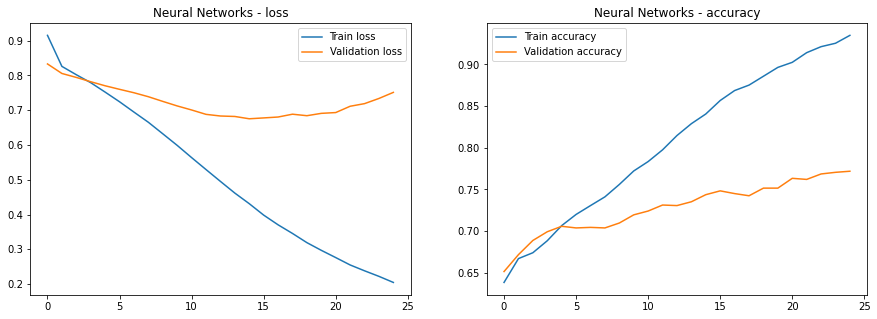

In [71]:
### Plotting the losses ###
plot_training(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING, input_data=INPUT_DATA[:-1])

Confusion Matrix saved at figures/costa_rican/Neural Networks_CM_costa_rican_data_testAcc=0.796.png


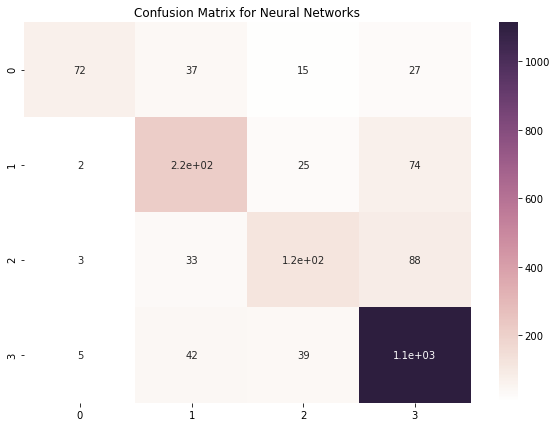

In [72]:
### Plotting the CM ###
plot_cm(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING, input_data=INPUT_DATA[:-1])

# Learning curves for "one-shot" algorithms <a name="learningcurves"></a>
[Table of Content](#menu)

In [73]:
def take_samples(x, percent):
    length_x = len(x)
    indexes = np.arange(length_x)
    new_indexes = random.choices(indexes, k=int(percent*length_x))
    new_x = x[new_indexes]

    return new_x


def plot_training_size_variation(model, x_train, y_train, x_test, y_test, graphs_path, do_save=True, do_plot=False, iterations=20):
    percentages = np.linspace(0.05, 1, iterations)

    hist = {'percentages': percentages}
    hist_acc_train = []
    hist_acc_test = []
    hist_f1_train = []
    hist_f1_test = []

    for percent in percentages:
        x_train_perc = take_samples(x_train, percent)
        y_train_perc = take_samples(y_train, percent)
        x_test_perc = x_test
        y_test_perc = y_test

        if model == "dt":
            model_clf, _ = train_decision_tree(x_train_perc, y_train_perc, x_test_perc, 
                                                          max_depth=MAX_DEPTH_DT, random_state=RANDOM_STATE)

        elif model == "adab":
            model_clf, _ = train_adaboost(x_train_perc, y_train_perc, x_test_perc, 
                                                     max_depth=MAX_DEPTH_BOOST, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

        elif model == "svm":
            model_clf, _ = train_svm(x_train_perc, y_train_perc, x_test_perc, 
                                                random_state=RANDOM_STATE)

        elif model == "knn":
            model_clf, _ = train_knn(x_train_perc, y_train_perc, x_test_perc, k=K_NEIGHB, weights=WEIGHTS)

        # Score
        y_pred_train = model_clf.predict(x_train_perc)
        y_pred_test = model_clf.predict(x_test_perc)

        acc_train = accuracy_score(y_train_perc, y_pred_train)
        acc_test = accuracy_score(y_test_perc, y_pred_test)
        hist_acc_train.append(acc_train)
        hist_acc_test.append(acc_test)
        
        f1_train = f1_score(y_train_perc, y_pred_train, average='macro')
        f1_test = f1_score(y_test_perc, y_pred_test, average='macro')
        hist_f1_train.append(f1_train)
        hist_f1_test.append(f1_test)

    hist['acc_train'] = hist_acc_train
    hist['acc_test'] = hist_acc_test
    hist['f1_train'] = hist_f1_train
    hist['f1_test'] = hist_f1_test

    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title(f'{model} - learning curves accuracy')
    ax[0].plot(hist["percentages"], hist["acc_train"], label="Training Accuracy")
    ax[0].plot(hist["percentages"], hist["acc_test"], label="Test Accuracy")
    ax[0].legend()
    ax[1].set_title(f'{model} - learning curves f1 score')
    ax[1].plot(hist["percentages"], hist["f1_train"], label="Training macro F1 score")
    ax[1].plot(hist["percentages"], hist["f1_test"], label="Test macro F1 score")
    ax[1].legend()
    if do_save:
        save_graph_path = f"{graphs_path}{model}_acc&f1_{INPUT_DATA[:-1]}.png"
        plt.savefig(save_graph_path)
        print(f"Training graph saved at {save_graph_path}")
    if do_plot: plt.show()

Training graph saved at figures/costa_rican/dt_acc&f1_costa_rican_data.png


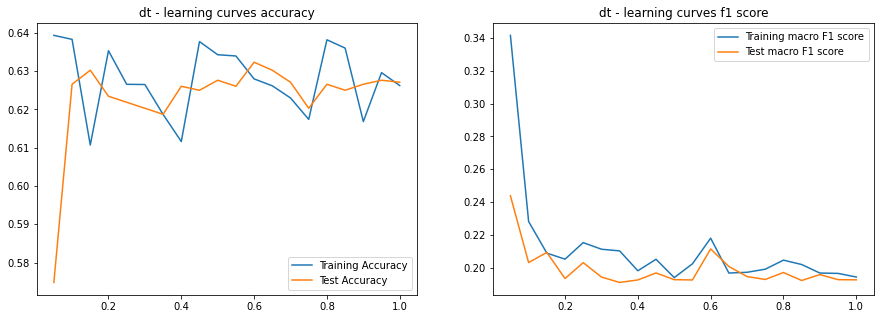

Wall time: 1.18 s


In [74]:
%%time
plot_training_size_variation('dt', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=20)

Training graph saved at figures/costa_rican/adab_acc&f1_costa_rican_data.png


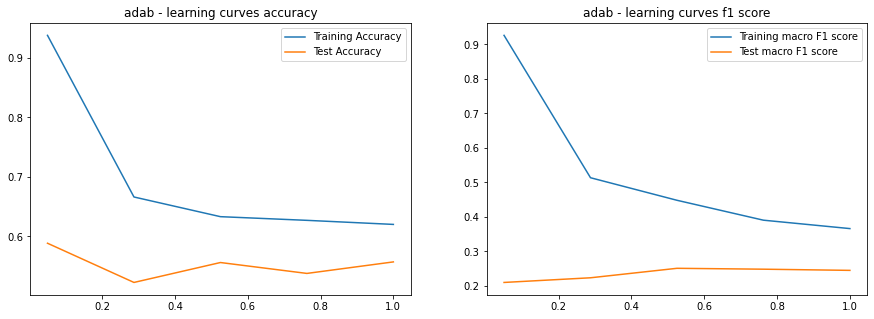

Wall time: 16.7 s


In [75]:
%%time
plot_training_size_variation('adab', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=5)

Training graph saved at figures/costa_rican/svm_acc&f1_costa_rican_data.png


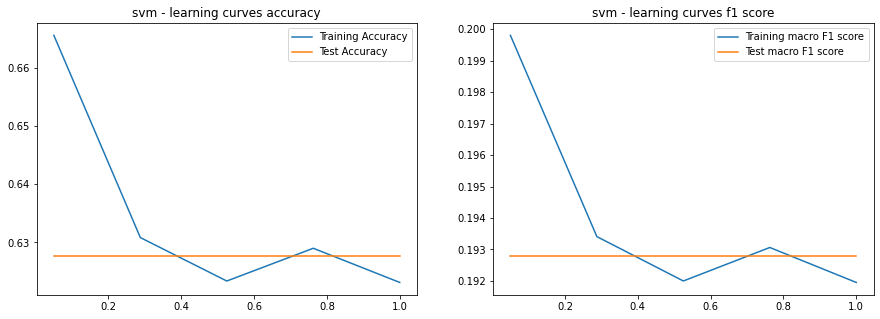

Wall time: 51.5 s


In [76]:
%%time
plot_training_size_variation('svm', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=5)

Training graph saved at figures/costa_rican/knn_acc&f1_costa_rican_data.png


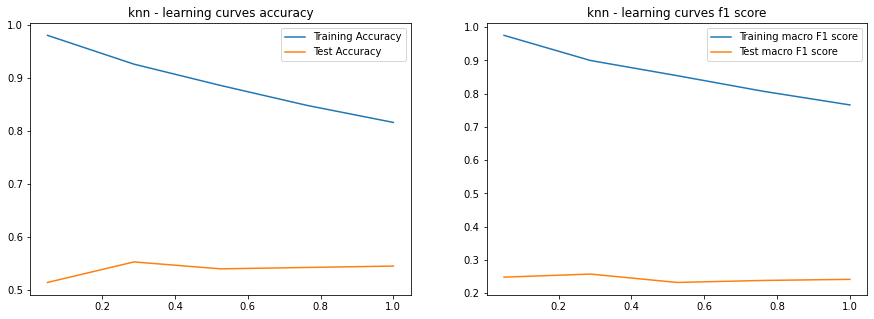

Wall time: 18.5 s


In [77]:
%%time
plot_training_size_variation('knn', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=5)

# Cross-validation <a name="crossval"></a>
[Table of Content](#menu)

Stratified-KFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold 

Inspired by https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6

In [78]:
K_folds = 5

skf = StratifiedKFold(n_splits=K_folds, random_state=RANDOM_STATE)
skf.get_n_splits(x_training, y_training)
print(skf)

StratifiedKFold(n_splits=5, random_state=17, shuffle=False)


D:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [79]:
for train_index, test_index in skf.split(x_training, y_training):
    x_train, x_val = x_training[train_index], x_training[test_index]
    y_train, y_val = y_training[train_index], y_training[test_index]

## Cross-validation on Decision Trees

best_depth = 19

In [80]:
# https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
from sklearn.model_selection import cross_val_score

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'dt'}_cv.png"
    plt.savefig(save_graph_path)

In [81]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_tree_depths = range(1, 50, 2)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(x_training, y_training, sm_tree_depths)

Wall time: 18.2 s


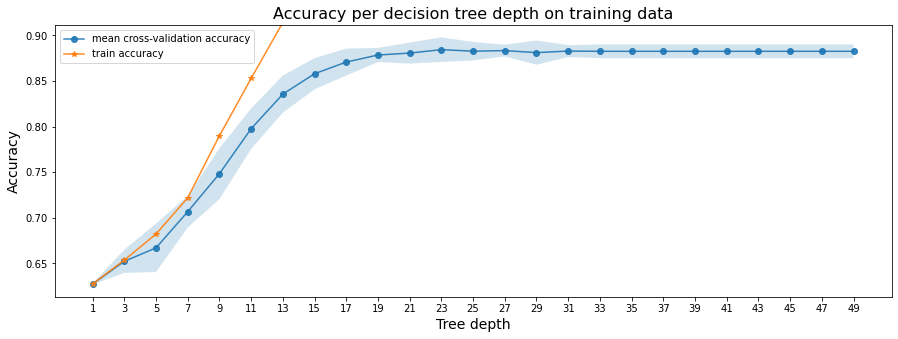

In [82]:
# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

## Cross-validation on Decision Trees with pruning

best_ccp_alpha = 0

In [195]:
# https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
from sklearn.model_selection import cross_val_score

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees_prune(X, y, list_ccp_alpha, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for ccp_alpha in list_ccp_alpha:
        tree_model = DecisionTreeClassifier(max_depth=19, random_state=RANDOM_STATE, ccp_alpha=ccp_alpha)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees_prune(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('cpp_alpha', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'dt_prune'}_cv.png"
    plt.savefig(save_graph_path)

In [198]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_tree_cpp_alpha = np.linspace(0, 0.005, 10)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees_prune(x_training, y_training, sm_tree_cpp_alpha)

Wall time: 8.36 s


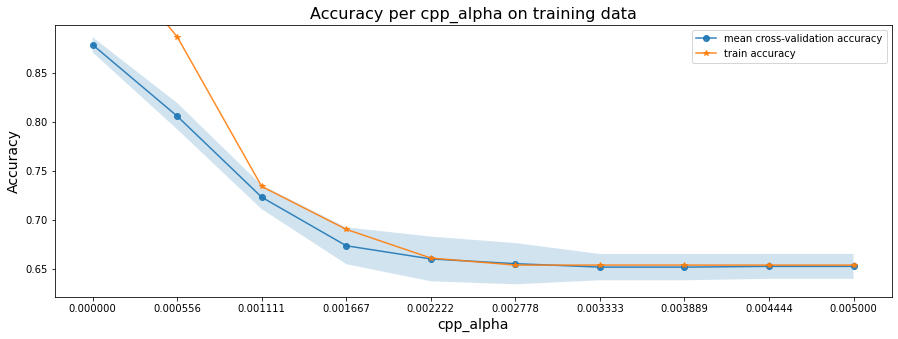

In [199]:
# plotting accuracy
plot_cross_validation_on_trees_prune(sm_tree_cpp_alpha, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per cpp_alpha on training data')

## Cross-validation on AdaBoost

best = 142

In [159]:
def run_cross_validation_on_adaboost(X, y, nb_estimators, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for nb in nb_estimators:
        decision_tree_boost = DecisionTreeClassifier(max_depth=21, random_state=RANDOM_STATE)
        adaboost_clf = AdaBoostClassifier(base_estimator=decision_tree_boost, n_estimators=nb)
        cv_scores = cross_val_score(adaboost_clf, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(adaboost_clf.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_adaboost(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('estimators', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'adaboost'}_cv.png"
    plt.savefig(save_graph_path)

In [160]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_estimators = range(102, 202, 20)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_adaboost(x_training, y_training, sm_estimators)

Wall time: 10min 42s


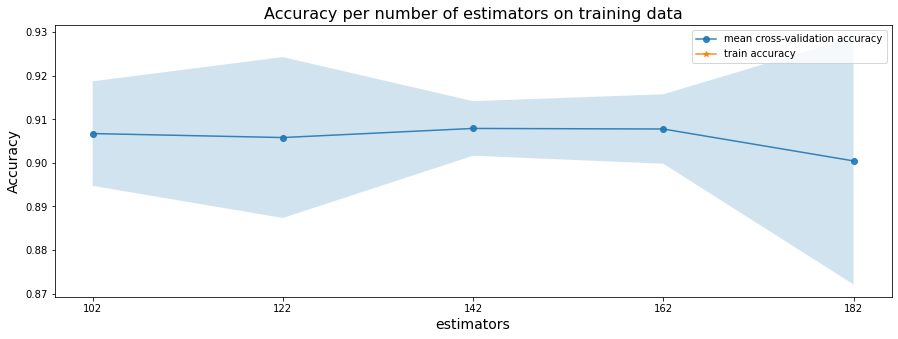

In [161]:
# plotting accuracy
plot_cross_validation_on_adaboost(sm_estimators, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per number of estimators on training data')

In [200]:
# https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
from sklearn.model_selection import cross_val_score

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_adaboost_prune(X, y, list_ccp_alpha, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for ccp_alpha in list_ccp_alpha:
        decision_tree_boost = DecisionTreeClassifier(max_depth=19, random_state=RANDOM_STATE, ccp_alpha=ccp_alpha)
        adaboost_clf = AdaBoostClassifier(base_estimator=decision_tree_boost, n_estimators=142)
        cv_scores = cross_val_score(adaboost_clf, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(adaboost_clf.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_adaboost_prune(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('cpp_alpha', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'adaboost_prune'}_cv.png"
    plt.savefig(save_graph_path)

In [201]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_adaboost_cpp_alpha = np.linspace(0, 0.005, 3)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_adaboost_prune(x_training, y_training, sm_adaboost_cpp_alpha)

Wall time: 6min 27s


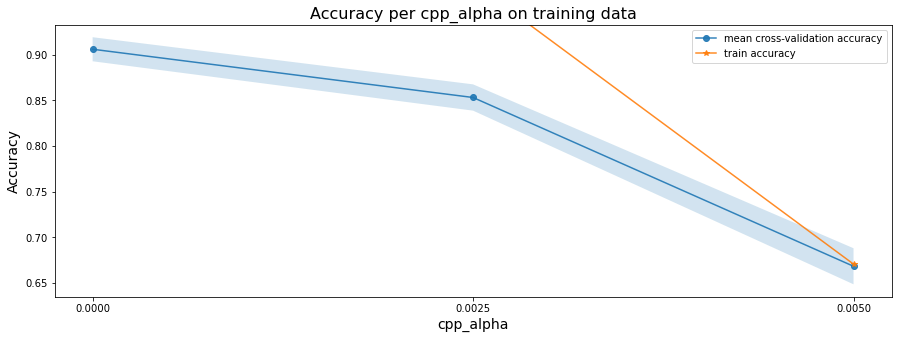

In [202]:
# plotting accuracy
plot_cross_validation_on_adaboost_prune(sm_adaboost_cpp_alpha, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per cpp_alpha on training data')

## Cross-validation on SVM

best_kernel = poly
best C = 100

In [203]:
def run_cross_validation_on_svm(X, y, list_kernels, C_list, gamma_list, cv=5, scoring='accuracy'):
    dict_kernels = {}
    for kernel in list_kernels:
        cv_scores_list = []
        cv_scores_std = []
        cv_scores_mean = []
        accuracy_scores = []
        for C in C_list:
            svm_model = SVC(C=C, random_state=RANDOM_STATE)
            cv_scores = cross_val_score(svm_model, X, y, cv=cv, scoring=scoring)
            cv_scores_list.append(cv_scores)
            cv_scores_mean.append(cv_scores.mean())
            cv_scores_std.append(cv_scores.std())
            accuracy_scores.append(svm_model.fit(X, y).score(X, y))
        cv_scores_mean = np.array(cv_scores_mean)
        cv_scores_std = np.array(cv_scores_std)
        accuracy_scores = np.array(accuracy_scores)

        dict_kernels[kernel] = [cv_scores_mean, cv_scores_std, accuracy_scores]
    
    return dict_kernels
  
# function for plotting cross-validation results
def plot_cross_validation_on_svm(depths, dict_kernels, title, save=False):
    fig, ax = plt.subplots(1, len(dict_kernels), figsize=(15,5))
    for idx, kernel in enumerate(dict_kernels.keys()):
        cv_scores_mean, cv_scores_std, accuracy_scores = dict_kernels[kernel]
        
        axis_C = np.arange(len(depths))
        
        ax[idx].plot(axis_C, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.75)
        ax[idx].fill_between(axis_C, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.15)
        ylim = plt.ylim()
        ax[idx].plot(axis_C, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
        ax[idx].set_title(title+f' for {kernel}', fontsize=16)
        ax[idx].set_xlabel('C', fontsize=14)
        ax[idx].set_ylabel('Accuracy', fontsize=14)
        ax[idx].set_ylim(ylim)
        ax[idx].set_xticks(axis_C)
        ax[idx].legend()
    save_graph_path = f"{GRAPHS_PATH}{'svm'}_cv.png"
    if save: plt.savefig(save_graph_path)

In [204]:
%%time
# fitting trees of depth 1 to 49, step=2
list_kernels = ['rbf', 'poly']
C_list = [1, 10, 100]
gamma_list = ['scale']
dict_kernels = run_cross_validation_on_svm(x_training, y_training, list_kernels, C_list, gamma_list)

Wall time: 6min 28s


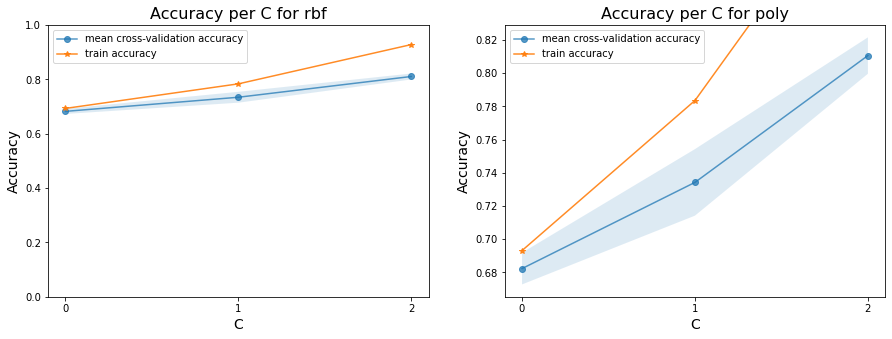

In [205]:
# plotting accuracy
plot_cross_validation_on_svm(C_list, dict_kernels, 
                               'Accuracy per C', save=True)

## Cross-validation on K-NN

Best = 2

In [186]:
def run_cross_validation_on_knn(X, y, kneighbors, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for k in kneighbors:
        knn_model = KNeighborsClassifier(n_neighbors=k, weights='distance')
        cv_scores = cross_val_score(knn_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(knn_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_knn(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('K', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'knn_fe'}_cv.png"
    plt.savefig(save_graph_path)

In [187]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_kneighbors = range(1, 15, 2)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_knn(x_training_fe, y_training_fe, sm_kneighbors)

Wall time: 41.2 s


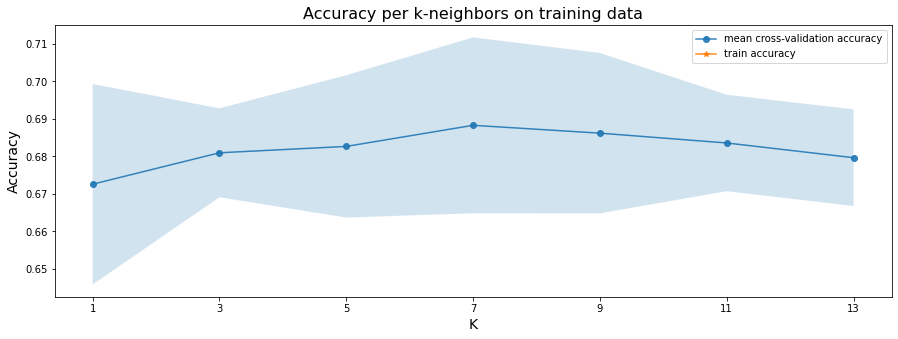

In [188]:
# plotting accuracy
plot_cross_validation_on_knn(sm_kneighbors, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per k-neighbors on training data')

## A better Neural Network (Advanced approach) <a name="advanced_nn"></a>
[Table of Content](#menu) 

[Simple Approach](#simple_nn)

In [167]:
GRAPHS_PATH = FIG_PATH
MODEL_TYPE = "Neural Networks"
SAVING = True

BATCH_SIZE = 64
EPOCHS = 400
LR = 5e-4
EARLYSTOP = True
SCHEDULER = True

In [172]:
#https://www.kaggle.com/mburakergenc/ttianic-minimal-pytorch-mlp
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(len(important_cols), 128)#len(features), 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=140, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


In [173]:
dataloaders_fe, dataset_sizes_fe = create_dataloaders(x_train_fe, y_train_fe, x_val_fe, y_val_fe, x_test_fe, y_test_fe, 
                                                      device=DEVICE, batch_size=BATCH_SIZE)

In [179]:
model = Net2()

###  Define loss function and optimizer ### 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-4) if SCHEDULER else None

# Define dictionary for training info
history_training = {'train_loss': [],
                    'val_loss': [],
                    'train_acc': [],
                    'val_acc': []}


### Training ###
model, history_training = train_model(model=model, hist=history_training, criterion=criterion, 
                                      optimizer=optimizer, dataloaders=dataloaders_fe, dataset_sizes=dataset_sizes_fe, 
                                      scheduler=lr_sched, num_epochs=EPOCHS, estop=EARLYSTOP, patience_es=15,device=DEVICE)



**TRAINING**

Epoch 0/399
----------
tensor(3770., dtype=torch.float64) 6116
train Loss: 1.0839 Acc: 0.6164
tensor(983., dtype=torch.float64) 1529
val Loss: 0.9078 Acc: 0.6429
Epoch complete in 0.4s

Validation loss decreased (inf --> 0.907808).  Saving model ...
Epoch 1/399
----------
tensor(3938., dtype=torch.float64) 6116
train Loss: 0.9578 Acc: 0.6439
tensor(995., dtype=torch.float64) 1529
val Loss: 0.8645 Acc: 0.6508
Epoch complete in 0.3s

Validation loss decreased (0.907808 --> 0.864549).  Saving model ...
Epoch 2/399
----------
tensor(3978., dtype=torch.float64) 6116
train Loss: 0.9113 Acc: 0.6504
tensor(1002., dtype=torch.float64) 1529
val Loss: 0.8501 Acc: 0.6553
Epoch complete in 0.3s

Validation loss decreased (0.864549 --> 0.850131).  Saving model ...
Epoch 3/399
----------
tensor(4026., dtype=torch.float64) 6116
train Loss: 0.9009 Acc: 0.6583
tensor(1005., dtype=torch.float64) 1529
val Loss: 0.8453 Acc: 0.6573
Epoch complete in 0.3s

Validation loss decreased (0.850131 

In [180]:
### Testing ###
history_training = test_model(model=model, hist=history_training, criterion=criterion, 
                              dataloaders=dataloaders_fe, dataset_sizes=dataset_sizes_fe, device=DEVICE)



**TESTING**


Test stats -  Loss: 0.5018 Acc: 85.04%
Inference on Testset complete in 0.7s



Training graph saved at figures/costa_rican/Neural Networks_losses&acc__testAcc=0.8504.png


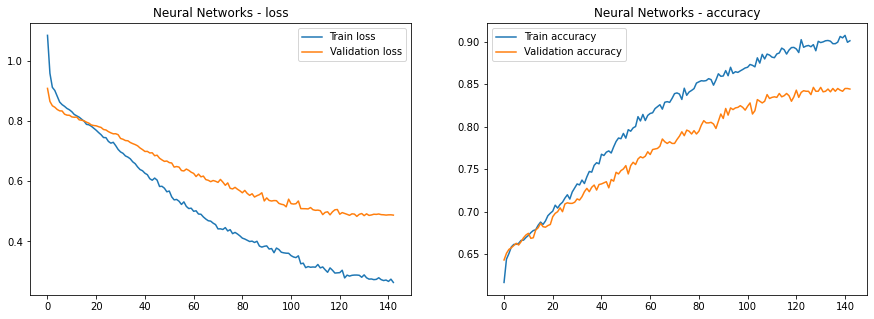

In [181]:
### Plotting the losses ###
plot_training(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING)

Confusion Matrix saved at figures/costa_rican/Neural Networks_CM__testAcc=0.8504.png


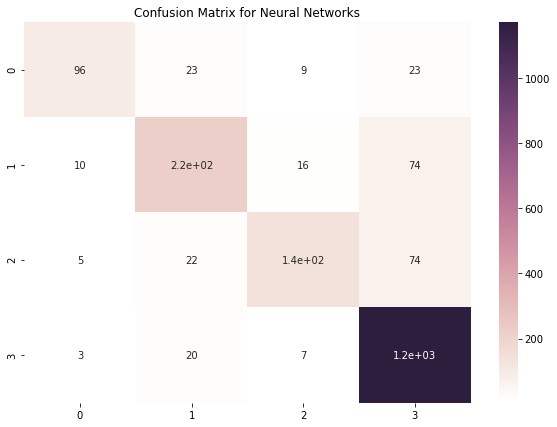

In [182]:
### Plotting the CM ###
plot_cm(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING)

# ROC results

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#receiver-operating-characteristic-roc

Implement Macro F1

In [98]:
nb_classes = len(set(train_csv['Target']))

def plot_ROC(y_test, y_pred_proba, model_name="model_name"):
    print(f"==============\n{model_name}\n==============\n")

    # Adapt array for sklearn's roc function
    y_test_proba = np.array([[0, 0, 0, 0] for _ in y_test])
    for idx in range(len(y_test_proba)):
        y_test_proba[idx][y_test[idx]] += 1

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_proba[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_proba.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    y_pred = np.array([np.argmax(x) for x in y_pred_proba])
    print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%\n")

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(nb_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen'])
    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(FIG_PATH+f'{model_name}.pdf')
    plt.show()

decision_trees

Overall accuracy: 64.64%



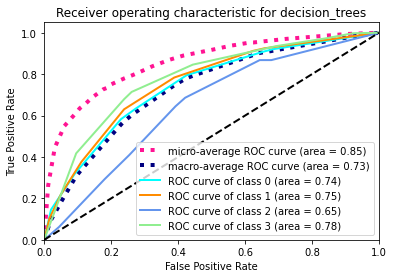

In [99]:
plot_ROC(y_test, y_pred_proba_trees, model_name="decision_trees")

adaboost

Overall accuracy: 70.45%



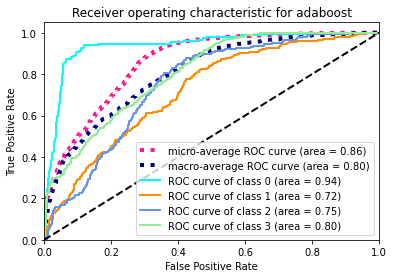

In [100]:
plot_ROC(y_test, y_pred_proba_boost, model_name="adaboost")

decision_trees_fe

Overall accuracy: 65.43%



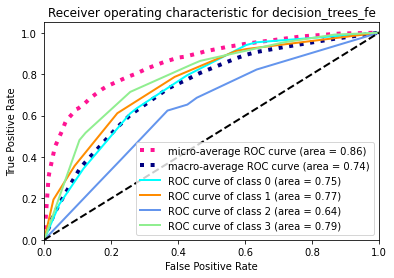

In [101]:
plot_ROC(y_test, y_pred_proba_trees_fe, model_name="decision_trees_fe")

adaboost_fe

Overall accuracy: 70.24%



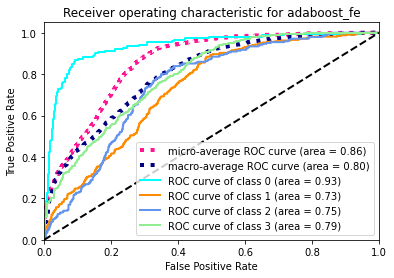

In [102]:
plot_ROC(y_test, y_pred_proba_boost_fe, model_name="adaboost_fe")